# Chat Intents

## Topic Modeling - LDA

In [9]:
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap

import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.phrases import Phrases, Phraser
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [10]:
data_sample = pd.read_csv('../data/processed/data_sample.csv')
data_sample.head()

,Unnamed: 0,text,category,cleaned_text
0,1024,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,im worried card might lost mail long usually take arrive
1,9405,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,got charged fee shouldnt cash
2,9368,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,charge making withdrawal took money account earlier charged
3,3414,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,issue account dont see cheque deposit made yesterday please assist
4,7402,Are there ways for other people to send me money?,receiving_money,way people send money


In [11]:
X = data_sample['cleaned_text']
X.head()

0              im worried card might lost mail long usually take arrive
1                                         got charged fee shouldnt cash
2           charge making withdrawal took money account earlier charged
3    issue account dont see cheque deposit made yesterday please assist
4                                                 way people send money
Name: cleaned_text, dtype: object

In [12]:
len(X)

1000

## LDA with Scikit-learn

In [13]:
count_vectorizer = CountVectorizer(ngram_range = (1, 2), max_df = 900, min_df = 10)

transformed_vector = count_vectorizer.fit_transform(X)
transformed_vector.shape

(1000, 144)

In [14]:
feature_names = count_vectorizer.get_feature_names()
feature_names[0:10]

['able',
 'accept',
 'account',
 'ago',
 'already',
 'amount',
 'app',
 'atm',
 'back',
 'balance']

In [15]:
%%time

perplexities = []
for NUM_TOPICS in range(5,101):
    lda_model = LatentDirichletAllocation(n_components = NUM_TOPICS, max_iter=20)
    lda = lda_model.fit_transform(transformed_vector)
    perplexities.append(lda_model.perplexity(transformed_vector))

CPU times: user 2min 42s, sys: 1.25 s, total: 2min 43s
Wall time: 2min 48s


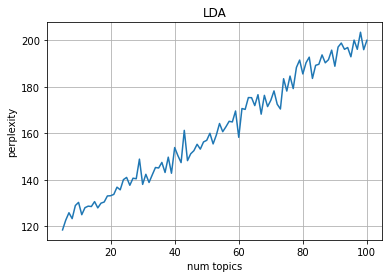

In [16]:
x = range(5, 101)
y = perplexities

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel = 'num topics', ylabel = 'perplexity', title = 'LDA')
ax.grid()

plt.show()

In [17]:
%%time

scores = []
for NUM_TOPICS in range(5,101):
    lda_model = LatentDirichletAllocation(n_components = NUM_TOPICS, max_iter=20)
    lda = lda_model.fit_transform(transformed_vector)
    scores.append(lda_model.score(transformed_vector))

CPU times: user 2min 46s, sys: 1.61 s, total: 2min 48s
Wall time: 2min 59s


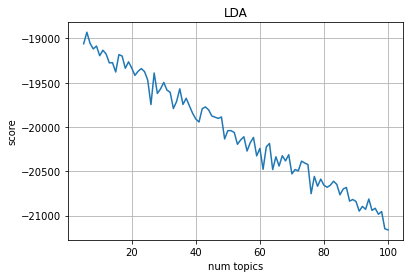

In [18]:
x = range(5, 101)
y = scores

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel = 'num topics', ylabel = 'score', title = 'LDA')
ax.grid()

plt.show()

### Evaluate a fixed number of topics

In [19]:
NUM_TOPICS = 15

lda_model = LatentDirichletAllocation(n_components = NUM_TOPICS, max_iter=20)

lda = lda_model.fit_transform(transformed_vector)
lda.shape

(1000, 15)

In [20]:
sum(lda[0])

1.0

In [21]:
lda_model.components_.shape

(15, 144)

In [22]:
lda_model.score(transformed_vector)

-19228.35628455235

In [23]:
def print_topic(identifier, top_words=10):
    for topic_id, topic_word_probs in enumerate(lda_model.components_):
        if topic_id == identifier:
            print(f"Topic {topic_id}: ")
            
            top_feature_names = [feature_names[i] for i in topic_word_probs.argsort()[: -top_words - 1: -1]]
            
            print(" ".join(top_feature_names))

In [24]:
for i in range(NUM_TOPICS):
    print_topic(i, top_words=10)

Topic 0: 
get card pin find cant stolen get card physical many used
Topic 1: 
card virtual virtual card disposable order work disposable card disposable virtual use accept
Topic 2: 
money account charge show see transfer money account ago dont deposit
Topic 3: 
exchange rate exchange rate time wrong tried currency receive one correct
Topic 4: 
top working use pay bank card im much today account
Topic 5: 
transaction identity debit direct hasnt direct debit gone verification yet cancel
Topic 6: 
app didnt make fund payment someone phone cant cost work
Topic 7: 
help please card new account want dont please help know new card
Topic 8: 
payment card card payment showing account made isnt balance day please
Topic 9: 
refund getting extra get statement mastercard declined visa reason atm
Topic 10: 
cash withdrawal atm cash withdrawal withdraw amount made still whats pending
Topic 11: 
need would like would like change sent account pin know friend
Topic 12: 
topup verify passcode need go wor

In [25]:
topics = []

for i in range(len(X)):
    topics.append(lda[i].argmax())

In [26]:
data_sample['topic'] = topics

data_sample.head()

,Unnamed: 0,text,category,cleaned_text,topic
0,1024,I'm worried my card might be lost in the mail? How long does it usually take to arrive?,card_delivery_estimate,im worried card might lost mail long usually take arrive,13
1,9405,I got charged a fee that shouldn't be there from my cash,cash_withdrawal_charge,got charged fee shouldnt cash,14
2,9368,Do you charge for making a withdrawal? I took some money out of my account earlier and I was charged for this.,cash_withdrawal_charge,charge making withdrawal took money account earlier charged,2
3,3414,Is there an issue with my account? I don't see a cheque deposit that I made yesterday. Please assist.,balance_not_updated_after_cheque_or_cash_deposit,issue account dont see cheque deposit made yesterday please assist,2
4,7402,Are there ways for other people to send me money?,receiving_money,way people send money,2


In [27]:
tsne = TSNE(n_components = 2, init = 'pca', random_state = 0)
lda_2d_tsne = tsne.fit_transform(lda)
lda_df_tsne = pd.DataFrame(lda_2d_tsne)
lda_df_tsne.shape

(1000, 2)

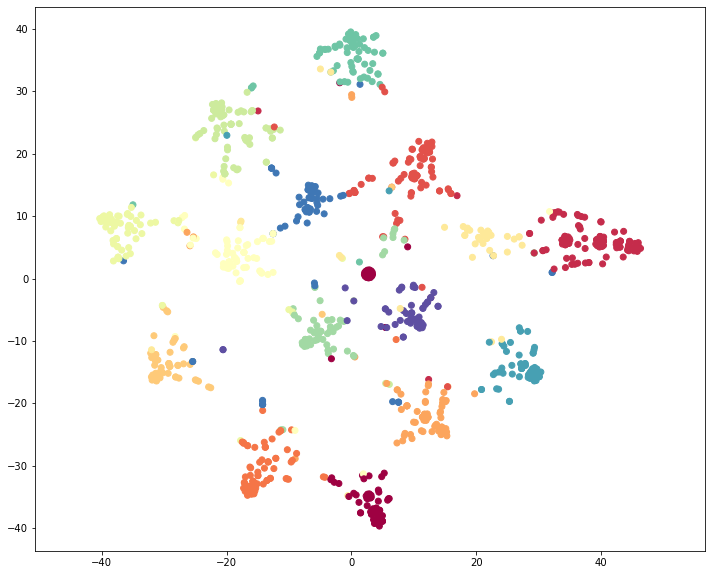

In [28]:
plt.subplots(figsize=(12, 10))
plt.axis('equal')

plt.scatter(lda_df_tsne[0], lda_df_tsne[1], c=data_sample['topic'], cmap = plt.cm.Spectral)

In [29]:
isomap = Isomap(n_neighbors = 20, n_components = 2)
lda_2d_isomap = isomap.fit_transform(lda)
lda_df_isomap = pd.DataFrame(lda_2d_isomap)

lda_df_isomap.head()

,0,1
0,0.320785,0.059012
1,0.203824,0.173898
2,0.009614,0.095724
3,-0.101968,0.039864
4,0.032937,0.071292


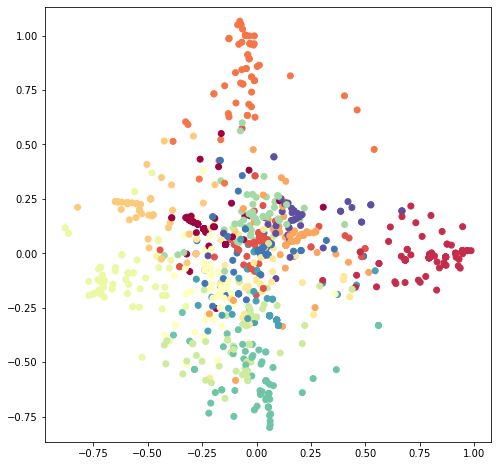

In [30]:
plt.subplots(figsize=(8,8))
plt.axis('equal')

plt.scatter(lda_df_isomap[0], lda_df_isomap[1], c = data_sample['topic'], cmap = plt.cm.Spectral) 

## LDA with Gensim

In [31]:
all_messages = data_sample['cleaned_text'].values.tolist()
all_tokens = [sent.split(' ') for sent in all_messages]

In [32]:
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram_phrases = Phrases(all_tokens, min_count=5)
bigram = Phraser(bigram_phrases)

for idx in range(len(all_tokens)):
    for token in bigram[all_tokens[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            all_tokens[idx].append(token)

In [33]:
bigram.phrasegrams

{'charged_fee': 11.54074074074074,
 'exchange_rate': 61.20364550597109,
 'virtual_card': 10.742710795902285,
 'whats_going': 22.777777777777775,
 'visa_mastercard': 69.55357142857143,
 'verify_topup': 13.248299319727892,
 'extra_fee': 22.91176470588235,
 'please_help': 19.378109452736318,
 'direct_debit': 148.3809523809524,
 'disposable_virtual': 39.343434343434346,
 'would_like': 53.05689102564103,
 'change_pin': 22.17267552182163,
 'long_take': 24.481458202388435,
 'google_pay': 29.285714285714285,
 'cash_withdrawal': 21.061643835616437,
 'didnt_make': 14.78178368121442,
 'still_pending': 10.730027548209367}

In [34]:
dictionary = Dictionary(all_tokens)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.9)

# Bag-of-words representation of the documents
corpus = [dictionary.doc2bow(text) for text in all_tokens]

In [35]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 139
Number of documents: 1000


Similar size corpus as the scikit-learn implementation above

### Iterate through different topic sizes

In [47]:
def compute_coherence_values(corpus, dictionary, num_topics):
    
    # Set training parameters
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  
    
    # Make a index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token
    
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       chunksize=chunksize,
                                       alpha='auto',
                                       eta='auto',
                                       iterations=iterations,
                                       num_topics=num_topics,
                                       passes=passes,
                                       eval_every=eval_every
                                      )
    
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=all_tokens, 
                                         dictionary=dictionary, 
                                         coherence='c_v')
    
    coherence = coherence_model_lda.get_coherence()
    #perplexity = lda_model.log_perplexity(corpus)  
    
    return coherence

In [49]:
%%time

coherence_scores = []
#perplexity_scores = []
for NUM_TOPICS in range(5,120):
    coherence = compute_coherence_values(corpus, dictionary, NUM_TOPICS)
    coherence_scores.append(coherence)
    #perplexity_scores.append(perplexity)

CPU times: user 7min 3s, sys: 6.33 s, total: 7min 9s
Wall time: 9min 15s


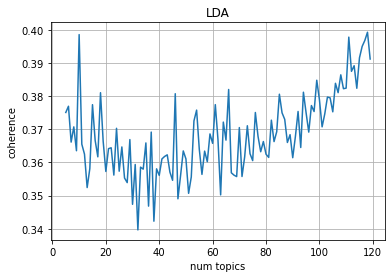

In [50]:
x = range(5, 120)
y = coherence_scores

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel = 'num topics', ylabel = 'coherence', title = 'LDA')
ax.grid()

plt.show()

In [51]:
list(range(5,120))[np.argmax(coherence_scores)]

118

#### Investigate 'optimal' topic number model

In [52]:
# Set training parameters
num_topics = 19
chunksize = 2000
passes = 20
iterations = 400
eval_every = 5  

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [53]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -10.2827.
[([(0.114762396, 'tried'),
   (0.11442425, 'using'),
   (0.09383422, 'card'),
   (0.045928713, 'today'),
   (0.04405603, 'something'),
   (0.042015024, 'yesterday'),
   (0.041413236, 'isnt'),
   (0.0393178, 'declined'),
   (0.039227035, 'reason'),
   (0.036865875, 'wrong'),
   (0.034241363, 'working'),
   (0.03253763, 'account'),
   (0.029197847, 'could'),
   (0.0283919, 'time'),
   (0.028238202, 'please'),
   (0.021199621, 'charged'),
   (0.020662168, 'showing'),
   (0.019162849, 'balance'),
   (0.017627526, 'check'),
   (0.01556041, 'still')],
  -7.61868241487866),
 ([(0.20433362, 'money'),
   (0.19693778, 'account'),
   (0.06770371, 'im'),
   (0.056820586, 'see'),
   (0.051578563, 'dont'),
   (0.04716341, 'time'),
   (0.04590393, 'hasnt'),
   (0.044708166, 'yet'),
   (0.039966382, 'gone'),
   (0.037543014, 'able'),
   (0.034754384, 'friend'),
   (0.033426028, 'transfer'),
   (0.016673703, 'sent'),
   (0.014691594, 'need'),
   (0.010867974, 'ago'),


In [56]:
topics = model.print_topics(num_words=6)
for topic in topics:
    print(topic)

(0, '0.198*"help" + 0.171*"please" + 0.081*"please_help" + 0.075*"card" + 0.065*"account" + 0.050*"stolen"')
(1, '0.106*"got" + 0.097*"one" + 0.094*"extra" + 0.081*"fee" + 0.063*"card" + 0.058*"going"')
(2, '0.160*"refund" + 0.125*"cant" + 0.055*"please" + 0.055*"money" + 0.042*"get" + 0.041*"account"')
(3, '0.204*"money" + 0.197*"account" + 0.068*"im" + 0.057*"see" + 0.052*"dont" + 0.047*"time"')
(4, '0.325*"payment" + 0.129*"card" + 0.116*"make" + 0.091*"didnt" + 0.062*"work" + 0.042*"much"')
(5, '0.299*"transfer" + 0.071*"bank" + 0.068*"amount" + 0.062*"withdraw" + 0.053*"money" + 0.047*"missing"')
(6, '0.245*"would" + 0.197*"like" + 0.143*"would_like" + 0.104*"purchase" + 0.065*"balance" + 0.040*"give"')
(7, '0.115*"tried" + 0.114*"using" + 0.094*"card" + 0.046*"today" + 0.044*"something" + 0.042*"yesterday"')
(8, '0.309*"top" + 0.123*"pin" + 0.095*"change" + 0.082*"pay" + 0.050*"cheque" + 0.045*"verification"')
(9, '0.173*"exchange" + 0.149*"rate" + 0.121*"exchange_rate" + 0.110*"

In [57]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model, 
                                     texts=all_tokens, 
                                     dictionary=dictionary, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

print('\nPerplexity: ', model.log_perplexity(corpus))


Coherence Score:  0.3623309388715617

Perplexity:  -4.946467755307579


### Visualize the topics

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
LDAvis_prepared

In [ ]:
pyLDAvis.disable_notebook()

## Hierarchical Dirichlet Process

In [58]:
hdp = gensim.models.HdpModel(corpus, dictionary)

In [59]:
topic_info = hdp.print_topics(num_topics=-1, num_words=10)
len(topic_info)

0

In [60]:
len(hdp.get_topics())

150

In theory, the HDP algorithm is supposed to be able to automatically determine the number of topics in the data, but this dataset might be too small for it to be useful. See https://radimrehurek.com/gensim/models/hdpmodel.html for more details.